## Метрики моделей классификации 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.datasets import load_iris

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold 

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.neighbors import KNeighborsClassifier 

import sklearn
# conda update scikit-learn
# или
# pip install --upgrade scikit-learn

sklearn.__version__


'1.6.1'

**Загрузим данные и сделаем задачу бинарной классификации**

In [4]:
df = pd.read_csv('dataset_citrus/train.csv')
X = df.drop(['name'],axis=1)
y = np.where(df.name=='grapefruit',1,0)

In [5]:
df.describe()

,diameter,weight,red,green,blue
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,9.973384,175.019732,153.723867,76.039733,11.364933
std,1.944686,29.153906,10.346053,11.740608,9.036016
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.467500,152.375000,147.000000,68.000000,2.000000
50%,9.980000,175.000000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,113.000000,56.000000


In [6]:
df.tail()

,name,diameter,weight,red,green,blue
7495,grapefruit,11.63,199.94,162,100,11
7496,orange,7.85,143.15,168,71,7
7497,grapefruit,10.26,178.19,143,73,19
7498,orange,8.65,155.07,162,93,16
7499,grapefruit,12.61,215.05,145,66,15


In [7]:
df.tail()

,name,diameter,weight,red,green,blue
7495,grapefruit,11.63,199.94,162,100,11
7496,orange,7.85,143.15,168,71,7
7497,grapefruit,10.26,178.19,143,73,19
7498,orange,8.65,155.07,162,93,16
7499,grapefruit,12.61,215.05,145,66,15


Сплитуем данные и отложим тестовый набор. Так как данных мало стратифицируем.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, 
                                                     test_size=0.3, stratify=y)

In [10]:
print(np.mean(y_train), np.mean(y_test))

0.5 0.5


## Контроль качества тренироваочного и тестового набора

array(['diameter', 'weight', 'red', 'green', 'blue'], dtype=object)

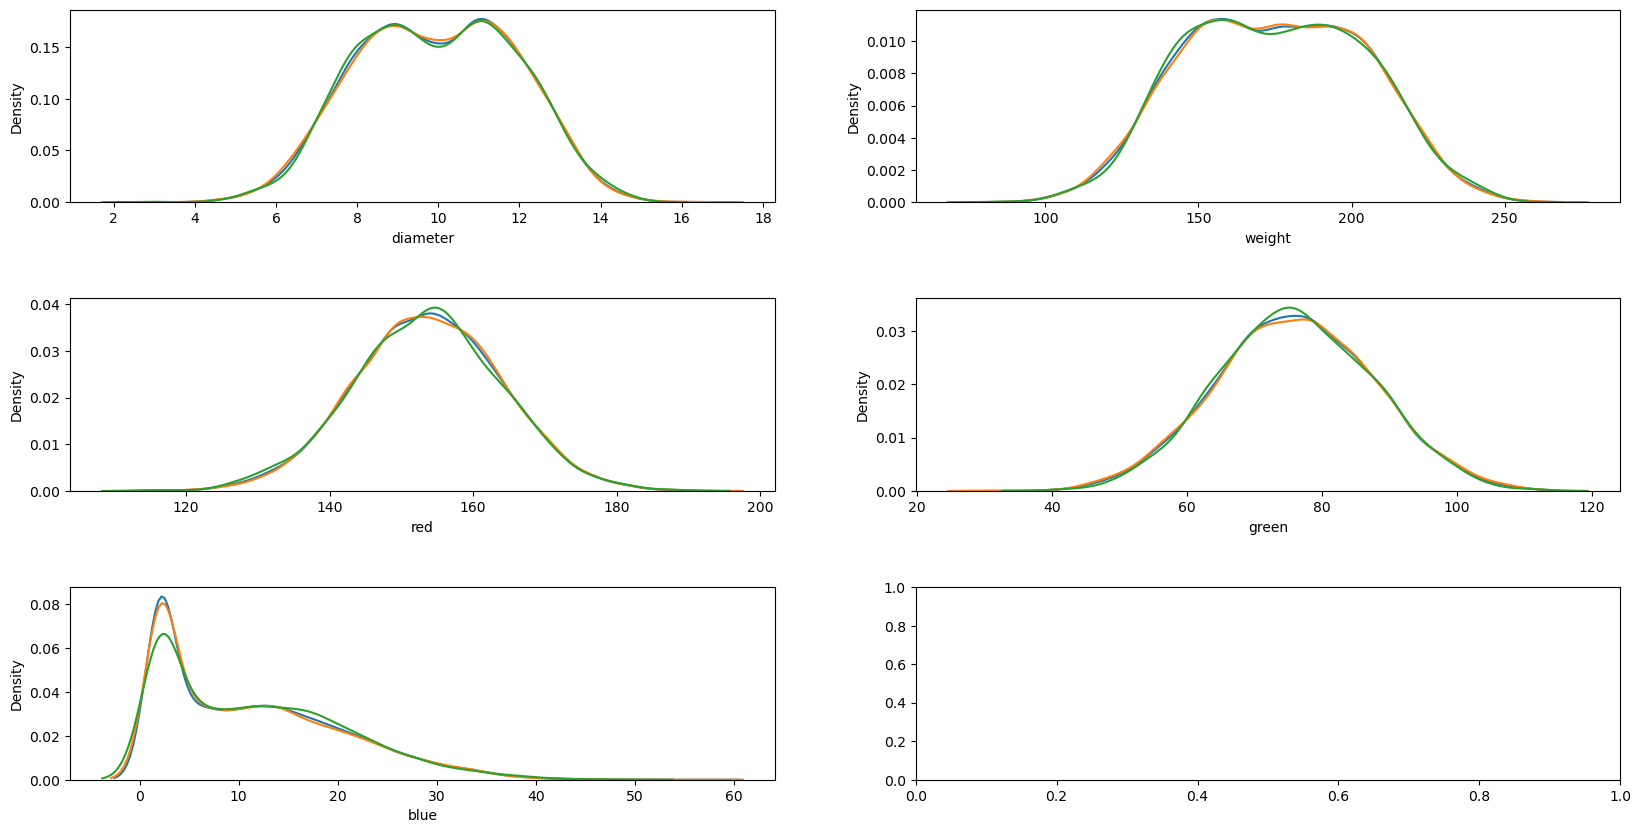

In [12]:
#list_columns_number = df.select_dtypes(exclude=['object']).columns
list_columns_number = X_test.select_dtypes(include=['number']).columns.values
display(list_columns_number)

fig, ax = plt.subplots(3,2,figsize = (20,10))
plt.subplots_adjust(hspace=0.5)
for axi, name in zip(ax.flat, list_columns_number):
    sns.kdeplot(df, x=name, ax=axi)
    sns.kdeplot(X_train, x=name, ax=axi)
    sns.kdeplot(X_test, x=name, ax=axi)

## Подбор оптимальных параметров

### Простая решетка

In [15]:
pipe_grid = Pipeline([
    ('preprocessing', MinMaxScaler()), 
    ('classifier', KNeighborsClassifier())
])

n_neighbors = np.arange(1,3,1)
p = np.arange(1,3,1)
weights=['uniform','distance']

param_grid =[
    {'preprocessing': [MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()], 
     'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': n_neighbors,
     'classifier__p': p,
     'classifier__weights': weights
     }
]

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_scv = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, n_jobs=-1)
grid_scv.fit(X_train,y_train)

NameError: name 'pipe' is not defined

In [ ]:
gridresults = pd.DataFrame(grid_scv.cv_results_).sort_values(["rank_test_score", "std_test_score"], ascending=[True, False]).T
display(gridresults)
display(gridresults.shape)

In [ ]:
mask = gridresults.index[gridresults.index.str.endswith("_test_score")][:-3]
gridresults.columns = gridresults.columns.values.astype(str)
tabl = gridresults.loc[mask].iloc[:,:10]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
sns.violinplot(data=tabl, ax=ax1);
sns.boxplot(data=tabl, ax=ax2);

### Случайная решетка

In [ ]:
grid_rscv = RandomizedSearchCV(pipe, param_grid, cv=cv, return_train_score=True, n_jobs=-1)
grid_rscv.fit(X_train,y_train)

In [ ]:
gridresults = pd.DataFrame(grid_rscv.cv_results_).sort_values(["rank_test_score", "std_test_score"], ascending=[True, False]).T
display(gridresults)
display(gridresults.shape)

In [ ]:
mask = gridresults.index[gridresults.index.str.endswith("_test_score")][:-3]
gridresults.columns = gridresults.columns.values.astype(str)
tabl = gridresults.loc[mask].iloc[:,:10]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
sns.violinplot(data=tabl, ax=ax1);
sns.boxplot(data=tabl, ax=ax2);

### Решетка с уполовинивонием на каждом шаге
(по умолчанию в три раза ...)

В первом раунде делается обычный поиск по сетке (grid search) для всех кандидатов, но на уменьшенной выборке (ее размер задает параметр min_resorces). На следующем раунде алгоритм уменьшает количество кандидатов в factor раз и увеличивает размер в выборки тоже в тоже число раз. Если все спланировать правильно, то на последней итерации будет использована (почти) вся выборка и число оставшихся кандидатов будет не больше кратности. Т.е. если кратность = 3, то в финале останется два или три кандидата.

Важно! Исходный размер выборки и кратность должны быть увязаны друг с другом и с размером полной выборки, чтобы на последней итерации была использована вся выборка и число кандидатов было не больше кратности. Иначе может получиться так, что достигнут полный размер выборки, а число кандидатов все еще больше кратности. Это не так страшно, просто на последней итерации будет много кандидатов, т.е. время работы алгоритма сократится не так сильно, как могло бы. Может получиться и наоборот: на последней итерации число кандидатов будет оптимальным, но размер выборки будет в разы меньше полного, что гораздо хуже.

Минимальный размер выборки можно и не задавать, например указав min_resources='smallest'. Тогда алгоритм сам подберет мин. размер так, чтобы на последней итерации получилось оптимальное сочетание.

In [ ]:
grid_hscv = HalvingGridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, n_jobs=-1)
grid_hscv.fit(X_train,y_train)

In [ ]:
gridresults = pd.DataFrame(grid_hscv.cv_results_).sort_values(["n_resources","rank_test_score", "std_test_score"], ascending=[False, True, False]).T
display(gridresults)
display(gridresults.shape)

In [ ]:
print(grid_hscv.n_resources_)
print(grid_hscv.n_candidates_)

In [ ]:
grid_hscv.best_index_

In [ ]:
grid_hscv.best_params_

### Случайная решетка с уполовинивонием на каждом шаге

In [ ]:
grid_hrscv = HalvingRandomSearchCV(pipe, param_grid, cv=cv, return_train_score=True, n_jobs=-1)
grid_hrscv.fit(X_train,y_train)

In [ ]:
grid_hrscv = HalvingRandomSearchCV(pipe, param_grid, cv=cv, return_train_score=True, n_jobs=-1, min_resources = 'exhaust', n_candidates = 18)
grid_hrscv.fit(X_train,y_train)

In [ ]:
print(grid_hrscv.n_resources_)
print(grid_hrscv.n_candidates_)

In [ ]:
grid_hrscv.best_index_

In [ ]:
grid_hrscv.best_params_

## построение ROC AUC

Построения графика ROC-AUC возможно эстиматора(оценщика модели)-`from_estimator` или предсказания - `from_predictions`

**Важное замечание!!!**
Внимание `RocCurveDisplay.from_predictions` **нельзя** брать результат команды `predict`, только результат `decision_function` или `predict_proba`, если этого нет, то команда не приненима!

In [ ]:
pipe = Pipeline([
    ('preprocessing', Normalizer()), 
    ('classifier', KNeighborsClassifier(n_neighbors = 2, p = 2, weights = 'distance'))
])

pipe.fit(X_train, y_train)
y_predict = pipe.predict(X_test)
y_predict_proba = pipe.predict_proba(X_test)

pipe.predict_proba(X_test)[:20] # decision_function в Knn нет

In [ ]:
from sklearn.metrics import RocCurveDisplay
fig, ax_roc = plt.subplots(1,1, figsize=(10, 5))

RocCurveDisplay.from_estimator(pipe, X_train, y_train, ax = ax_roc, name = 'pipe corect est');
RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax = ax_roc, name = 'pipe corect est');
RocCurveDisplay.from_predictions(y_test, pipe.predict_proba(X_test)[:,1], ax = ax_roc, name = 'pipe corect predict');
RocCurveDisplay.from_predictions(y_test, y_predict, ax = ax_roc, name = 'ЭТО ОШИБКА')

In [ ]:
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1,2, figsize=(10, 5))

RocCurveDisplay.from_estimator(pipe, X_train, y_train, ax = ax_roc, name = 'pipe train');
RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax = ax_roc, name = 'pipe test');
DetCurveDisplay.from_estimator(pipe, X_train, y_train, ax = ax_det, name = 'pipe train');
DetCurveDisplay.from_estimator(pipe, X_test, y_test, ax = ax_det, name = 'pipe test');


# ВНИМАНИЕ для дальнейших экспериментов возьмем три НЕ ПЕРЕОБУЧЕННЫХ МОДЕЛИ, иначе будет непонятно ... 

In [ ]:
pipe_1 = make_pipeline(Normalizer(),     KNeighborsClassifier(n_neighbors = 24, p = 1))
pipe_2 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 30, p = 10))
pipe_3 = make_pipeline(RobustScaler(),   KNeighborsClassifier(n_neighbors = 10, p = 20))

pipe_1.fit(X_train,y_train)
pipe_2.fit(X_train,y_train)
pipe_3.fit(X_train,y_train)

y_pred_1 = pipe_1.predict(X_test)
y_pred_2 = pipe_2.predict(X_test)
y_pred_3 = pipe_3.predict(X_test)

print("По умолчанию мерикa accuracy")
print("Тренировака: ", pipe_1.score(X_train,y_train), "   Тест : ", pipe_1.score(X_test,y_test))
print("Тренировака: ", pipe_2.score(X_train,y_train), "   Тест : ", pipe_2.score(X_test,y_test))
print("Тренировака: ", pipe_3.score(X_train,y_train), "   Тест : ", pipe_3.score(X_test,y_test))

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

RocCurveDisplay.from_estimator(pipe_1, X_test, y_test, ax = ax1, name = 'pipe_1');
RocCurveDisplay.from_estimator(pipe_2, X_test, y_test, ax = ax1, name = 'pipe_2');
RocCurveDisplay.from_estimator(pipe_3, X_test, y_test, ax = ax1, name = 'pipe_3');


PrecisionRecallDisplay.from_estimator(pipe_1, X_test, y_test, ax = ax2, name = 'pipe_1');
PrecisionRecallDisplay.from_estimator(pipe_2, X_test, y_test, ax = ax2, name = 'pipe_2');
PrecisionRecallDisplay.from_estimator(pipe_3, X_test, y_test, ax = ax2, name = 'pipe_3');

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import TunedThresholdClassifierCV, FixedThresholdClassifier

score = "accuracy"
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats = 7, random_state=42)
cv_ths = TunedThresholdClassifierCV(estimator = pipe_1, scoring=score, cv=cv).fit(X_train, y_train)
cv_ths.best_threshold_

In [ ]:
pipe_ths = FixedThresholdClassifier(pipe_1, threshold = 0.42424242424242425).fit(X_train, y_train)
y_predict = pipe_1.predict(X_test)
y_predict_ths = pipe_ths.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
from IPython.display import display_html, display

df1 = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T
df2 = pd.DataFrame(classification_report(y_test, y_predict_ths, output_dict=True)).T

df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('origin')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('thresholds')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, make_scorer, confusion_matrix

pos_label, neg_label = 1, 0

def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

tpr_score = recall_score  # TPR and recall are the same metric
scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(tpr_score, pos_label=pos_label),
}


def plot_roc_pr_curves(vanilla_model, tuned_model, cv_model, *, title):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))
    
    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = ("Vanilla model", "Tuned model")
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((vanilla_model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scoring["recall"](est, X_test, y_test),
            scoring["precision"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        RocCurveDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scoring["fpr"](est, X_test, y_test),
            scoring["tpr"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )

    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()

    axs[2].plot(
        cv_model.cv_results_["thresholds"],
        cv_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        cv_model.best_threshold_,
        cv_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)

In [ ]:
title = "Сравнение моделей до/после тюнинга порога"


cv_ths = TunedThresholdClassifierCV(estimator = pipe_1, scoring=score, store_cv_results=True, cv=cv).fit(X_train,y_train)
print(cv_ths.best_threshold_)
ths = 0.42424242424242425
pipe_ths = FixedThresholdClassifier(pipe_1, threshold = ths).fit(X_train, y_train)

plot_roc_pr_curves( vanilla_model = pipe_1, 
                    tuned_model = pipe_ths,
                    cv_model = cv_ths,
                    title = title)